In [1]:
import torch
import cv2
from torchvision.models.detection import MaskRCNN_ResNet50_FPN_Weights
import torchvision

import matplotlib.pyplot as plt
import numpy as np

In [2]:
# 1. load model
model = torchvision.models.detection.maskrcnn_resnet50_fpn(
    weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT
)

# 2. load image
im_raw = cv2.imread("cat.png")
im_np = im_raw.copy()

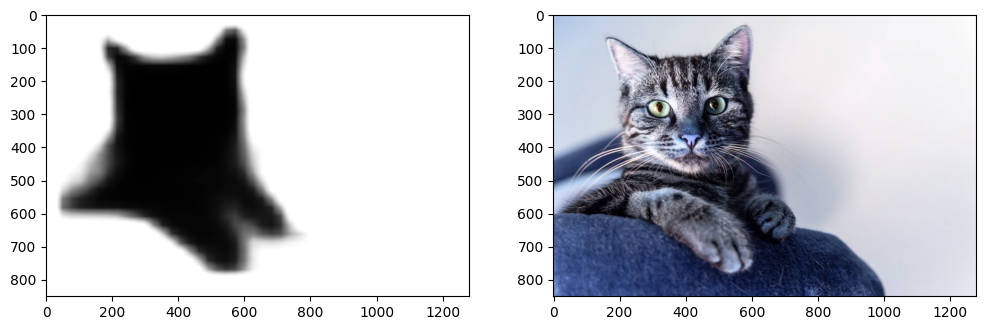

In [3]:
# 3. Change image to tensor of given type
im_raw = torch.from_numpy(im_raw).type(torch.float32)
X = im_raw.permute(2, 0, 1)

# 4. Conver image values to range 0 to 1
Xmin = torch.min(X)
Xmax = torch.max(X)
X = X - Xmin
X = X / Xmax

# 5. Make predictions
model.eval()
predictions = model([X])

# 6. Choose the right mask and detach from grading
output_masks = predictions[0]["masks"]
mask_0 = output_masks[0].detach()

# 7. Convert to range 0 to 255
mask_0 = mask_0 * Xmax
mask_0 = mask_0 + Xmin
mask_0 = torch.round(mask_0)

# 8. Calculate a sharper mask
predicted_mask = (mask_0[0]) - torch.min(mask_0[0]) - 60
# predicted_mask = predicted_mask * 10000000
predicted_mask[predicted_mask < 0] = 0
predicted_mask[predicted_mask > 255] = 255
predicted_mask = torch.round(predicted_mask)

# 9. add a dimension for displaying
predicted_mask = predicted_mask.unsqueeze(2).type(torch.uint8).numpy()

# 10. show mask and the image
plt.figure(figsize=(12, 10))
plt.subplot(1, 2, 1)
plt.imshow(predicted_mask, cmap="Grays")
plt.subplot(1, 2, 2)
plt.imshow(im_np)
plt.show()

In [4]:
# 11. Calculate treshold
_, threshold = cv2.threshold(predicted_mask, np.mean(predicted_mask), 255, cv2.THRESH_BINARY_INV)

# 12. Get contours from the mask
contours, hierarchy = cv2.findContours(predicted_mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
cnt = sorted(contours, key=cv2.contourArea)[-1]

# 13. Getting proper mask from contours
mask = np.zeros((im_np.shape[0], im_np.shape[1]), dtype="uint8")
cv2.drawContours(mask, [cnt], -1, 255, -1)
mask= cv2.bitwise_not(mask)

# 14. Putting mask on the image
finalImage = cv2.bitwise_and(im_np, im_np, mask = mask)

In [5]:
# 15. Display finalImage
cv2.imshow("masked cat", finalImage)
cv2.waitKey(0)
cv2.destroyAllWindows() 